## Lesson resources

* [https://youtu.be/Q0z-l2KRYFY Lesson video]
* [http://forums.fast.ai/t/lesson-7-discussion Forum discussion]
* [http://wiki.fast.ai/index.php/Lesson_7_Notes Lesson 7 notes]
* The notebooks:
** [https://github.com/fastai/courses/blob/master/deeplearning1/nbs/lesson6.ipynb Lesson 6] updated with pure python RNN and theano GRU details
** [https://github.com/fastai/courses/blob/master/deeplearning1/nbs/lesson7.ipynb Lesson 7] has the various CNN architectures applied to the kaggle fisheries competition.

* The python scripts:
** [https://github.com/fastai/courses/blob/master/deeplearning1/nbs/vgg16bn.py VGG with batch normalization] - also adds 'size' and 'include_top' parameters
** [https://github.com/fastai/courses/blob/master/deeplearning1/nbs/resnet50.py resnet50.py] - The resnet architecture

## More information

* [https://culurciello.github.io/tech/2016/06/04/nets.html Network architecture review] (really great)
* [http://techtalks.tv/talks/fully-convolutional-networks-for-semantic-segmentation/61606/ Fully convolutional net]
* [https://keras.io/getting-started/functional-api-guide/#multi-input-and-multi-output-models [Multi input and multi output nets in Keras]
* [http://www.wildml.com/2015/10/recurrent-neural-network-tutorial-part-4-implementing-a-grulstm-rnn-with-python-and-theano/ Gated recurrent units (GRUs) ]

## Fisheries competition

In this notebook we're going to investigate a range of different architectures for the [Kaggle fisheries competition](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring). The video states taht vgg.py and vgg_ft() from utils.py have been updated to include VGG with batch normalization, but this is not the case. We've instead created a new file [vgg_bn.py] and an additional method vgg_ft_bn() (which is already in utils.py) which we use in this notbook.

### actions
1. create validation and sample set
2. rearrange image files into their respective directories
3. fine tune and train model
4. generate prediction
5. validate prediction
6. sumit predictions to kaggle

In [1]:
%matplotlib inline
import imp
import utils
imp.reload(utils)
from utils import *

Using TensorFlow backend.


In [2]:
path = './data/fish'
batch_size = 64

## Data Preparation

In [88]:
import os
import glob
import numpy as np
from pathlib import Path
from shutil import copy

source = [x for x in Path(path + '/org').iterdir() if x.is_dir()]
target = {'train': 10, 'valid': 5}

# create folders: train, valid
for name in target.keys():
    Path(path + '/' + name).mkdir(exist_ok = True)

def drop(dst, src):
    dst.mkdir(exist_ok = True) # ignore FileExistsrror
    print(src, '-->', dst)
    #copy(src, dst)

for src in source: 
    imgs = sorted(Path(src).glob('*.jpg'))
    print(len(imgs), src)
    imgs = np.random.permutation(imgs)
    total = np.sum(list(target.values())) * 5.0
    start = 0
    for key, val in target.items():
        size = np.int32(len(imgs) * val / total)
        dst = Path(path + '/' + key + '/' + src.name)
        for index in range(0, size):
            img = imgs[start + index]
            drop(dst, img)
        start += size


1719 data\fish\org\ALB
data\fish\org\ALB\img_02229.jpg --> data\fish\train\ALB
data\fish\org\ALB\img_02883.jpg --> data\fish\train\ALB
data\fish\org\ALB\img_02414.jpg --> data\fish\train\ALB
data\fish\org\ALB\img_06989.jpg --> data\fish\train\ALB
data\fish\org\ALB\img_01901.jpg --> data\fish\train\ALB
data\fish\org\ALB\img_02328.jpg --> data\fish\train\ALB
data\fish\org\ALB\img_05973.jpg --> data\fish\train\ALB
data\fish\org\ALB\img_05266.jpg --> data\fish\train\ALB
data\fish\org\ALB\img_01822.jpg --> data\fish\train\ALB
data\fish\org\ALB\img_04907.jpg --> data\fish\train\ALB
data\fish\org\ALB\img_07384.jpg --> data\fish\train\ALB
data\fish\org\ALB\img_00793.jpg --> data\fish\train\ALB
data\fish\org\ALB\img_03593.jpg --> data\fish\train\ALB
data\fish\org\ALB\img_02046.jpg --> data\fish\train\ALB
data\fish\org\ALB\img_04954.jpg --> data\fish\train\ALB
data\fish\org\ALB\img_06158.jpg --> data\fish\train\ALB
data\fish\org\ALB\img_07614.jpg --> data\fish\train\ALB
data\fish\org\ALB\img_052

data\fish\org\ALB\img_05279.jpg --> data\fish\train\ALB
data\fish\org\ALB\img_00617.jpg --> data\fish\train\ALB
data\fish\org\ALB\img_02719.jpg --> data\fish\train\ALB
data\fish\org\ALB\img_01072.jpg --> data\fish\train\ALB
data\fish\org\ALB\img_07463.jpg --> data\fish\train\ALB
data\fish\org\ALB\img_00829.jpg --> data\fish\train\ALB
data\fish\org\ALB\img_04112.jpg --> data\fish\train\ALB
data\fish\org\ALB\img_07917.jpg --> data\fish\train\ALB
data\fish\org\ALB\img_02034.jpg --> data\fish\train\ALB
data\fish\org\ALB\img_01333.jpg --> data\fish\train\ALB
data\fish\org\ALB\img_07549.jpg --> data\fish\train\ALB
data\fish\org\ALB\img_03233.jpg --> data\fish\train\ALB
data\fish\org\ALB\img_05131.jpg --> data\fish\train\ALB
data\fish\org\ALB\img_01334.jpg --> data\fish\train\ALB
data\fish\org\ALB\img_04301.jpg --> data\fish\train\ALB
data\fish\org\ALB\img_02292.jpg --> data\fish\train\ALB
data\fish\org\ALB\img_03575.jpg --> data\fish\train\ALB
data\fish\org\ALB\img_03119.jpg --> data\fish\tr

data\fish\org\ALB\img_04164.jpg --> data\fish\valid\ALB
data\fish\org\ALB\img_00719.jpg --> data\fish\valid\ALB
data\fish\org\ALB\img_06372.jpg --> data\fish\valid\ALB
data\fish\org\ALB\img_07810.jpg --> data\fish\valid\ALB
data\fish\org\ALB\img_03451.jpg --> data\fish\valid\ALB
data\fish\org\ALB\img_05808.jpg --> data\fish\valid\ALB
data\fish\org\ALB\img_01841.jpg --> data\fish\valid\ALB
data\fish\org\ALB\img_01032.jpg --> data\fish\valid\ALB
data\fish\org\ALB\img_05465.jpg --> data\fish\valid\ALB
data\fish\org\ALB\img_01507.jpg --> data\fish\valid\ALB
data\fish\org\ALB\img_02586.jpg --> data\fish\valid\ALB
data\fish\org\ALB\img_03635.jpg --> data\fish\valid\ALB
data\fish\org\ALB\img_03216.jpg --> data\fish\valid\ALB
data\fish\org\ALB\img_05297.jpg --> data\fish\valid\ALB
data\fish\org\ALB\img_01455.jpg --> data\fish\valid\ALB
data\fish\org\ALB\img_07207.jpg --> data\fish\valid\ALB
data\fish\org\ALB\img_07662.jpg --> data\fish\valid\ALB
data\fish\org\ALB\img_06437.jpg --> data\fish\va

data\fish\org\NoF\img_04351.jpg --> data\fish\train\NoF
data\fish\org\NoF\img_02329.jpg --> data\fish\train\NoF
data\fish\org\NoF\img_03933.jpg --> data\fish\train\NoF
data\fish\org\NoF\img_05733.jpg --> data\fish\train\NoF
data\fish\org\NoF\img_00720.jpg --> data\fish\train\NoF
data\fish\org\NoF\img_05984.jpg --> data\fish\train\NoF
data\fish\org\NoF\img_02015.jpg --> data\fish\train\NoF
data\fish\org\NoF\img_03893.jpg --> data\fish\train\NoF
data\fish\org\NoF\img_01892.jpg --> data\fish\train\NoF
data\fish\org\NoF\img_02441.jpg --> data\fish\train\NoF
data\fish\org\NoF\img_05352.jpg --> data\fish\train\NoF
data\fish\org\NoF\img_07758.jpg --> data\fish\train\NoF
data\fish\org\NoF\img_05998.jpg --> data\fish\train\NoF
data\fish\org\NoF\img_05814.jpg --> data\fish\train\NoF
data\fish\org\NoF\img_00849.jpg --> data\fish\train\NoF
data\fish\org\NoF\img_07597.jpg --> data\fish\train\NoF
data\fish\org\NoF\img_05178.jpg --> data\fish\train\NoF
data\fish\org\NoF\img_03506.jpg --> data\fish\tr

data\fish\org\SHARK\img_00096.jpg --> data\fish\train\SHARK
data\fish\org\SHARK\img_00033.jpg --> data\fish\valid\SHARK
data\fish\org\SHARK\img_07533.jpg --> data\fish\valid\SHARK
data\fish\org\SHARK\img_02557.jpg --> data\fish\valid\SHARK
data\fish\org\SHARK\img_03131.jpg --> data\fish\valid\SHARK
data\fish\org\SHARK\img_01986.jpg --> data\fish\valid\SHARK
data\fish\org\SHARK\img_01916.jpg --> data\fish\valid\SHARK
data\fish\org\SHARK\img_01820.jpg --> data\fish\valid\SHARK
data\fish\org\SHARK\img_07080.jpg --> data\fish\valid\SHARK
data\fish\org\SHARK\img_06385.jpg --> data\fish\valid\SHARK
data\fish\org\SHARK\img_05019.jpg --> data\fish\valid\SHARK
data\fish\org\SHARK\img_06000.jpg --> data\fish\valid\SHARK
734 data\fish\org\YFT
data\fish\org\YFT\img_00217.jpg --> data\fish\train\YFT
data\fish\org\YFT\img_00801.jpg --> data\fish\train\YFT
data\fish\org\YFT\img_06846.jpg --> data\fish\train\YFT
data\fish\org\YFT\img_01974.jpg --> data\fish\train\YFT
data\fish\org\YFT\img_06763.jpg --

data\fish\org\YFT\img_05676.jpg --> data\fish\valid\YFT


In [19]:
batches = get_batches(path + '/train', batch_size = batch_size)
val_batches = get_batches(path + '/valid', batch_size = batch_size * 2, shuffle = False)

(val_classes, trn_classes, val_labels, trn_labels, val_filenames, filenames, test_filenames) = get_classes(path + '/')

Found 499 images belonging to 8 classes.
Found 247 images belonging to 8 classes.
Found 499 images belonging to 8 classes.
Found 247 images belonging to 8 classes.
Found 1000 images belonging to 1 classes.


Sometimes it's helpful to have just the filenames, without the path.

In [213]:
raw_filenames = [f.split(os.sep)[-1] for f in filenames]
raw_test_filenames = [f.split(os.sep)[-1] for f in test_filenames]
raw_val_filenames = [f.split(os.sep)[-1] for f in val_filenames]
print(filenames[0], raw_filenames[0])
print(val_filenames[0], raw_val_filenames[0])

ALB\img_00019.jpg img_00019.jpg
ALB\img_00010.jpg img_00010.jpg


IndexError: list index out of range

## vgg approach

We start with our usual VGG approach. We will be using VGG with batch normalization. We explained how to add batch normalization to VGG in the [imagenet batch notebook]. VGG with batch normalization is implemented in [vgg_bn.py], and there is a version of vgg_ft (our fine tuning function) with batch norm called vgg_ft_bn in [util.py].

### Initial model

First we create a simple fine-tuned VGG model to be our starting point.

In [114]:
from vgg16bn import Vgg16BN
model = vgg_ft_bn(8)

In [99]:
trn = get_data(path + '/train')
val = get_data(path + '/valid')

Found 499 images belonging to 8 classes.
Found 247 images belonging to 8 classes.


In [107]:
imp.reload(utils)
from utils import *
test = get_data(path + '/test')

Found 0 images belonging to 0 classes.


In [108]:
save_array(path + '/results/trn.dat', trn)
save_array(path + '/results/val.dat', val)

In [109]:
save_array(path + '/results/test.dat', test)

In [110]:
trn = load_array(path + '/results/trn.dat')
val = load_array(path + '/results/val.dat')

In [111]:
test = load_array(path + '/results/test.dat')

In [112]:
gen = image.ImageDataGenerator()

In [116]:
model.compile(optimizer = Adam(1e-3), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model.fit(trn, trn_labels, batch_size = batch_size, epochs = 3, validation_data = (val, val_labels))

Train on 499 samples, validate on 247 samples
Epoch 1/3


In [118]:
model.save_weights(path + '/results/ft1.h5')

### Precompute convolutional output

We pre-compute the output of the last convolution layer of VGG, since we're unlikely to need to fine-tune those layers. (All following analysis will be done on just the pre-computed convolutional features.)

In [120]:
model.load_weights(path + '/results/ft1.h5')

In [123]:
conv_layers, fc_layers = split_at(model, Convolution2D)

In [124]:
conv_model = Sequential(conv_layers)

In [125]:
conv_feat = conv_model.predict(trn)
conv_val_feat = conv_model.predict(val)

In [126]:
conv_test_feat = conv_model.predict(test)

ValueError: Error when checking : expected lambda_2_input to have 4 dimensions, but got array with shape (0, 1)

In [127]:
save_array(path + '/results/conv_feat.dat', conv_feat)
save_array(path + '/results/conv_val_feat.dat', conv_val_feat)

In [ ]:
save_array(path + '/results/conv_test_feat.dat', conv_test_feat)

In [128]:
conv_feat = load_array(path + '/results/conv_feat.dat')
conv_val_feat = load_array(path + '/results/conv_val_feat.dat')

In [130]:
conv_test_feat = load_array(path + '/results/conv_test_feat.dat')

FileNotFoundError: [Errno 2] No such file or directory: './data/fish/results/conv_test_feat.dat\\meta\\sizes'

In [129]:
conv_val_feat.shape

(247, 512, 14, 14)

### Train model

We can now create our first baseline model - a simple 3-layer FC net.

In [130]:
def get_bn_layers(p):
    return [
        MaxPooling2D(input_shape = conv_layers[-1].output_shape[1:]),
        BatchNormalization(axis = 1),
        Dropout(p/4),
        Flatten(),
        Dense(512, activation = 'relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(512, activation = 'relu'),
        BatchNormalization(),
        Dropout(p/2),
        Dense(8, activation = 'softmax')
    ]

In [131]:
p = 0.6

In [134]:
bn_model = Sequential(get_bn_layers(p))
bn_model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [136]:
bn_model.fit(conv_feat, trn_labels, batch_size = batch_size, epochs = 3, validation_data = (conv_val_feat, val_labels))

Train on 499 samples, validate on 247 samples
Epoch 1/3
499/499 [==============================] - 12s - loss: 2.1535 - acc: 0.3487 - val_loss: 5.0908 - val_acc: 0.5142
Epoch 2/3
499/499 [==============================] - 8s - loss: 1.0238 - acc: 0.6794 - val_loss: 3.1890 - val_acc: 0.6680
Epoch 3/3
499/499 [==============================] - 8s - loss: 0.5626 - acc: 0.8216 - val_loss: 2.5735 - val_acc: 0.7409


In [137]:
bn_model.optimizer.lr = 1e-4

In [139]:
bn_model.fit(conv_feat, trn_labels, batch_size = batch_size, epochs = 7, validation_data = (conv_val_feat, val_labels))

Train on 499 samples, validate on 247 samples
Epoch 1/7
499/499 [==============================] - 8s - loss: 0.3562 - acc: 0.8958 - val_loss: 1.9846 - val_acc: 0.7328
Epoch 2/7
499/499 [==============================] - 8s - loss: 0.2468 - acc: 0.9339 - val_loss: 1.5597 - val_acc: 0.7773
Epoch 3/7
499/499 [==============================] - 8s - loss: 0.1831 - acc: 0.9499 - val_loss: 1.4672 - val_acc: 0.8057
Epoch 4/7
499/499 [==============================] - 8s - loss: 0.1015 - acc: 0.9659 - val_loss: 1.2804 - val_acc: 0.8016
Epoch 5/7
499/499 [==============================] - 8s - loss: 0.0861 - acc: 0.9800 - val_loss: 1.1444 - val_acc: 0.8219
Epoch 6/7
499/499 [==============================] - 8s - loss: 0.0568 - acc: 0.9840 - val_loss: 1.0872 - val_acc: 0.8300
Epoch 7/7
499/499 [==============================] - 8s - loss: 0.0601 - acc: 0.9880 - val_loss: 1.0682 - val_acc: 0.8462


In [141]:
bn_model.save_weights(path + '/models/conv_512_6.h5')

In [143]:
bn_model.evaluate(conv_val_feat, val_labels)

247/247 [==============================] - 2s     


[1.0681925703156814, 0.84615384542990313]

In [144]:
bn_model.load_weights(path + '/models/conv_512_6.h5')

## Multi input

The images are of different sizes, which are likely to represent the boat they came from (since diffent boats will be use different cameras). Perhaps this creates some data leakage that we can take advantage of to get a better Kaggle leaderboard position> To find out, first we create arrays of the file sizes for each image:

In [153]:
sizes = [PIL.Image.open(path + '/train/' + f).size for f in filenames]
id2size = list(set(sizes))
size2id = {o:i for i,o in enumerate(id2size)}

In [154]:
import collections
collections.Counter(sizes)

Counter({(1192, 670): 22,
         (1244, 700): 1,
         (1276, 718): 32,
         (1280, 720): 285,
         (1280, 750): 89,
         (1280, 924): 10,
         (1280, 974): 47,
         (1334, 750): 4,
         (1518, 854): 7,
         (1732, 974): 2})

Then we one-hot encode them (since we want to treat them as categorical) and normalize the data.

In [155]:
trn_sizes_orig = to_categorical([size2id[o] for o in sizes], len(id2size))

In [157]:
raw_val_sizes = [PIL.Image.open(path + '/valid/' + f).size for f in val_filenames]
val_sizes = to_categorical([size2id[o] for o in raw_val_sizes], len(id2size))

In [158]:
trn_sizes = trn_sizes_orig - trn_sizes_orig.mean(axis = 0) / trn_sizes_orig.std(axis = 0)
val_sizes = val_sizes - trn_sizes_orig.mean(axis = 0) / trn_sizes_orig.std(axis = 0)

To use this additional "meta-data", we create a model with multiple input layers - sz_inp will be our input for the size information.

In [159]:
p = 0.6

In [163]:
inp = Input(conv_layers[-1].output_shape[1:])
sz_inp = Input((len(id2size),))
bn_inp = BatchNormalization()(sz_inp)

x = MaxPooling2D()(inp)
x = BatchNormalization(axis = 1)(x)
x = Dropout(p/4)(x)
x = Flatten()(x)
x = Dense(512, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x = merge([x, bn_inp], 'concat')
x = Dense(8, activation = 'softmax')(x)

C:\Users\hjkim\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  from ipykernel import kernelapp as app
C:\Users\hjkim\Anaconda3\lib\site-packages\keras-2.0.8-py3.6.egg\keras\legacy\layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


When we compile the model, we have to specify all the input layers in an array.

In [165]:
model = Model([inp, sz_inp], x)
model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

Adn when we train the model, we have to provide all the input layer's data in an array.

In [166]:
model.fit([conv_feat, trn_sizes], trn_labels, batch_size = batch_size, epochs = 3, validation_data = ([conv_val_feat, val_sizes], val_labels))

Train on 499 samples, validate on 247 samples
Epoch 1/3
499/499 [==============================] - 13s - loss: 2.2043 - acc: 0.3467 - val_loss: 4.9715 - val_acc: 0.5466
Epoch 2/3
499/499 [==============================] - 8s - loss: 1.0147 - acc: 0.6774 - val_loss: 2.7582 - val_acc: 0.7126
Epoch 3/3
499/499 [==============================] - 8s - loss: 0.7118 - acc: 0.7816 - val_loss: 2.1437 - val_acc: 0.7611


In [167]:
bn_model.optimizer.lr = 1e-4

In [170]:
bn_model.fit(conv_feat, trn_labels, batch_size = batch_size, epochs = 8, validation_data = (conv_val_feat, val_labels))

Train on 499 samples, validate on 247 samples
Epoch 1/8
499/499 [==============================] - 8s - loss: 0.0342 - acc: 0.9960 - val_loss: 1.0334 - val_acc: 0.8462
Epoch 2/8
499/499 [==============================] - 8s - loss: 0.0404 - acc: 0.9900 - val_loss: 0.9796 - val_acc: 0.8462
Epoch 3/8
499/499 [==============================] - 9s - loss: 0.0218 - acc: 0.9980 - val_loss: 0.9534 - val_acc: 0.8502
Epoch 4/8
499/499 [==============================] - 8s - loss: 0.0312 - acc: 0.9920 - val_loss: 0.9105 - val_acc: 0.8502
Epoch 5/8
499/499 [==============================] - 8s - loss: 0.0150 - acc: 0.9980 - val_loss: 0.8912 - val_acc: 0.8502
Epoch 6/8
499/499 [==============================] - 8s - loss: 0.0177 - acc: 0.9980 - val_loss: 0.8785 - val_acc: 0.8502
Epoch 7/8
499/499 [==============================] - 8s - loss: 0.0145 - acc: 0.9980 - val_loss: 0.8779 - val_acc: 0.8502
Epoch 8/8
499/499 [==============================] - 8s - loss: 0.0132 - acc: 1.0000 - val_loss: 0.8

The model idid not show an improvement by using the leakage, other than in the early epochs. This is most likely because the information about what boat the picture came from is eadily identified from the image itself, so the meta-data tuned out not to add any additional information.

## Bounding boxes & mulit output

### improve / view bounding boxes

A kaggle user has created bounding box annotations for each fish in each training set image. You can download them [from here](). We will see if we can utilize this additional information. First, we'll load in the data, and keep just the largest bounding box for each image.

In [172]:
import ujson as json

In [183]:
anno_classes = ['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft']

In [179]:
def get_annotations():
    annot_urls = {
        '5458/bet_labels.json': 'bd20591439b650f44b36b72a98d3ce27',
        '5459/shark_labels.json': '94b1b3110ca58ff4788fb659eda7da90',
        '5460/dol_labels.json': '91a25d29a29b7e8b8d7a8770355993de',
        '5461/yft_labels.json': '9ef63caad8f076457d48a21986d81ddc',
        '5462/alb_labels.json': '731c74d347748b5272042f0661dad37c',
        '5463/lag_labels.json': '92d75d9218c3333ac31d74125f2b380a'
    }
    cache_subdir = os.path.abspath(os.path.join(path, 'annos'))
    url_prefix = 'https://kaggle2.blob.core.windows.net/forum-message-attachments/147157/'
    
    if not os.path.exists(cache_subdir):
        os.makedirs(cache_subdir)
        
    for url_suffix, md5_hash in annot_urls.items():
        fname = url_suffix.rsplit('/', 1)[-1]
        get_file(fname, url_prefix + url_suffix, cache_subdir = cache_subdir, md5_hash = md5_hash)

In [180]:
get_annotations()

16384/30731 [==============>...............] - ETA: 0s

In [202]:
bb_json = {}
for c in anno_classes:
    if c == 'other': continue # no annotation file for 'other' class
    j = json.load(open('{}/annos/{}_labels.json'.format(path, c), 'r'))
    for l in j:
        if 'annotations' in l.keys() and len(l['annotations']) > 0:
            bb_json[l['filename'].split('/')[-1]] = sorted(l['annotations'], key = lambda x: x['height'] * x['width'])[-1]

In [203]:
bb_json['img_04908.jpg']

{'class': 'rect',
 'height': 246.75000000000074,
 'width': 432.8700000000013,
 'x': 465.3000000000014,
 'y': 496.32000000000147}

In [214]:
file2idx = {o:i for i,o in enumerate(raw_filenames)}
val_file2idx = {o:i for i,o in enumerate(raw_val_filenames)}

Fro any images that have no annotations, we'll create an empty bounding box.

In [215]:
empty_box = {'height': 0, 'width':0, 'x' :0., 'y':0.}

In [216]:
for f in raw_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_box
    else : print(f)
for f in raw_val_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_box
    else : print(f)

img_00019.jpg
img_00039.jpg
img_00130.jpg
img_00163.jpg
img_00219.jpg
img_00269.jpg
img_00274.jpg
img_00281.jpg
img_00319.jpg
img_00341.jpg
img_00342.jpg
img_00344.jpg
img_00385.jpg
img_00482.jpg
img_00507.jpg
img_00561.jpg
img_00596.jpg
img_00617.jpg
img_00632.jpg
img_00633.jpg
img_00634.jpg
img_00687.jpg
img_00690.jpg
img_00701.jpg
img_00706.jpg
img_00742.jpg
img_00744.jpg
img_00747.jpg
img_00762.jpg
img_00782.jpg
img_00793.jpg
img_00810.jpg
img_00829.jpg
img_00869.jpg
img_01000.jpg
img_01023.jpg
img_01028.jpg
img_01038.jpg
img_01045.jpg
img_01046.jpg
img_01072.jpg
img_01077.jpg
img_01079.jpg
img_01127.jpg
img_01282.jpg
img_01291.jpg
img_01333.jpg
img_01334.jpg
img_01361.jpg
img_01396.jpg
img_01398.jpg
img_01401.jpg
img_01489.jpg
img_01509.jpg
img_01620.jpg
img_01638.jpg
img_01652.jpg
img_01663.jpg
img_01690.jpg
img_01713.jpg
img_01733.jpg
img_01753.jpg
img_01756.jpg
img_01822.jpg
img_01823.jpg
img_01896.jpg
img_01901.jpg
img_01911.jpg
img_01921.jpg
img_02034.jpg
img_02046.jpg
img_02

Finally, we convert the dictionary into an array, and convert the coordinates to our resized 224x224 images.

In [217]:
bb_params = ['height', 'width', 'x', 'y']
def convert_bb(bb, size):
    bb = [bb[p] for p in bb_params]
    conv_x = (224. / size[0])
    conv_y = (224. / size[1])
    bb[0] = bb[0] * conv_y
    bb[1] = bb[1] * conv_x
    bb[2] = max(bb[2] * conv_x, 0)
    bb[3] = max(bb[3] * conv_y, 0)
    return bb

In [218]:
trn_bbox = np.stack([convert_bb(bb_json[f], s) for f,s in zip(raw_filenames, sizes)],).astype(np.float32)
val_bbox = np.stack([convert_bb(bb_json[f], s) for f,s in zip(raw_val_filenames, raw_val_sizes)],).astype(np.float32)

Now we can check our work by drawing one of the annotations.

In [219]:
def create_rect(bb, color = 'red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color = color, fill = False, lw = 3)

def show_bb(i):
    bb = val_bbox[i]
    plot(val[i])
    plt.gca().add_patch(create_rect(bb))
    print(bb)

[  65.8      14.0647  116.466   128.5293]


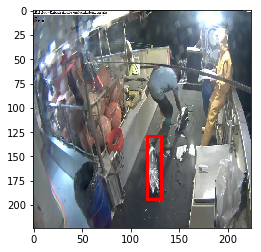

In [220]:
show_bb(0)

### Create and train model

Since we're not allowed (by the kaggle rules) to manually annotate the test set, we'll need to create a model taht predicts the locations of the bounding box on each image. Th do so, we create a model with multiple outputs: it will predict both the type of fish (the 'class'), and the 4 bounding box coordinates. We prefer this approach to only predicting the bounding box coordinates, since we hope that gving the model more context about what it's looking for will help it with both tasks.

In [221]:
p = 0.6

In [223]:
inp  =Input(conv_layers[-1].output_shape[1:])
x = MaxPooling2D()(inp)
x = BatchNormalization(axis = 1)(x)
x = Dropout(p/4)(x)
x = Flatten()(x)
x = Dense(512, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation = 'relu')(x)
x = BatchNormalization()(x)
x_bb = Dense(4, name = 'bb')(x)
x_class = Dense(8, activation = 'softmax', name = 'class')(x)

Since we have multiple outputs, we need to provide them to the model constructor in an array, and we also need to say what loss function to use for each. We also weight the bounding obox loss function down by 1000x since the scale of the cross-entropy laoss and the MSE is very different.

In [225]:
model = Model([inp], [x_bb, x_class])
model.compile(Adam(lr = 0.01), loss = ['mse', 'categorical_crossentropy'], metrics = ['accuracy'], loss_weights = [0.001, 1.0])

In [227]:
model.fit(conv_feat, [trn_bbox, trn_labels], batch_size = batch_size, epochs = 3, validation_data = (conv_val_feat, [val_bbox, val_labels]))

Train on 499 samples, validate on 247 samples
Epoch 1/3
499/499 [==============================] - 13s - loss: 7.5852 - bb_loss: 4306.4624 - class_loss: 3.2787 - bb_acc: 0.3948 - class_acc: 0.3707 - val_loss: 359.6443 - val_bb_loss: 346227.7809 - val_class_loss: 13.4165 - val_bb_acc: 0.4211 - val_class_acc: 0.1579
Epoch 2/3
499/499 [==============================] - 9s - loss: 5.2399 - bb_loss: 3981.3498 - class_loss: 1.2585 - bb_acc: 0.4048 - class_acc: 0.6553 - val_loss: 262.9938 - val_bb_loss: 255181.2332 - val_class_loss: 7.8125 - val_bb_acc: 0.4899 - val_class_acc: 0.4818
Epoch 3/3
499/499 [==============================] - 8s - loss: 4.1934 - bb_loss: 3471.4735 - class_loss: 0.7219 - bb_acc: 0.4068 - class_acc: 0.7776 - val_loss: 129.9023 - val_bb_loss: 124688.3738 - val_class_loss: 5.2139 - val_bb_acc: 0.4980 - val_class_acc: 0.6559


In [228]:
model.optimizer.lr = 1e-5

In [229]:
model.fit(conv_feat, [trn_bbox, trn_labels], batch_size = batch_size, epochs = 10, validation_data = (conv_val_feat, [val_bbox, val_labels]))

Train on 499 samples, validate on 247 samples
Epoch 1/10
499/499 [==============================] - 8s - loss: 3.2533 - bb_loss: 2739.4374 - class_loss: 0.5138 - bb_acc: 0.4609 - class_acc: 0.8497 - val_loss: 69.2765 - val_bb_loss: 63517.4533 - val_class_loss: 5.7590 - val_bb_acc: 0.5101 - val_class_acc: 0.5385
Epoch 2/10
499/499 [==============================] - 9s - loss: 2.2296 - bb_loss: 1837.6038 - class_loss: 0.3920 - bb_acc: 0.4890 - class_acc: 0.8717 - val_loss: 40.0026 - val_bb_loss: 36308.5548 - val_class_loss: 3.6941 - val_bb_acc: 0.5263 - val_class_acc: 0.7004
Epoch 3/10
499/499 [==============================] - 8s - loss: 1.1848 - bb_loss: 1007.4457 - class_loss: 0.1774 - bb_acc: 0.5611 - class_acc: 0.9379 - val_loss: 22.1847 - val_bb_loss: 18466.0398 - val_class_loss: 3.7187 - val_bb_acc: 0.5304 - val_class_acc: 0.6721
Epoch 4/10
499/499 [==============================] - 9s - loss: 0.7751 - bb_loss: 627.8645 - class_loss: 0.1473 - bb_acc: 0.5872 - class_acc: 0.9519 - v

Excitingly, it turned out that the classification model is much improved by giving it this additional task. Let's see how well the bounding box omodel did by taking a look at its output.

In [230]:
pred = model.predict(conv_val_feat[0:10])

In [231]:
def show_bb_pred(i):
    bb = val_bbox[i]
    bb_pred = pred[0][i]
    plt.figure(figsize = (6, 6))
    plot(val[i])
    ax = plt.gca()
    ax.add_patch(create_rect(bb_pred, 'yellow'))
    ax.add_patch(create_rect(bb))

The image shows that it can find fish that are trickly for us to see!

In [ ]:
show_bb_pred(6)

In [233]:
model.evaluate(conv_val_feat, [val_bbox, val_labels])

247/247 [==============================] - 2s     


[2.8277315996919086,
 1302.4715581113992,
 1.5252599421783015,
 0.55465587165191588,
 0.81376518242754914]

In [234]:
model.save_weights(path + '/models/bn_anno.h5')

In [235]:
model.load_weights(path + '/models/bn_anno.h5')

## Large size

### Setup data

Let's see if we get better results if we use larger images. We'll use 640x360, since it's the same shape as the most common size we saw earlier(12800x720), without being too bug.

In [3]:
trn = get_data(path + '/train', (360, 360))
val = get_data(path + '/valid', (360, 360))

Found 499 images belonging to 8 classes.
Found 247 images belonging to 8 classes.


The image shows that tihings are much clearer at this size.

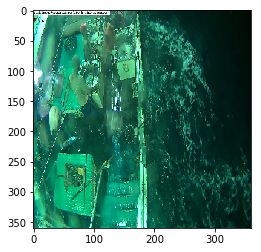

In [4]:
plot(trn[0])

In [5]:
test = get_data(path + '/test', (360, 360))

Found 1000 images belonging to 1 classes.


In [6]:
save_array(path + '/results/trn_640.dat', trn)
save_array(path + '/results/val_640.dat', val)

In [7]:
save_array(path + '/results/test_640.dat', test)

In [3]:
trn = load_array(path + '/results/trn_640.dat')
val = load_array(path + '/results/val_640.dat')
test = load_array(path + '/results/test_640.dat')

We can now create our VGG model - we'll need to tell it we're not using the noramlized 224x224 images, which also means it won't include the fully connected layers (since they don't make sense for non-default sizes). We will alsow remove the last max pooling layer, since we don't want to throw awaqy information yet.

In [5]:
vgg640 = Vgg16BN((360, 360)).model
vgg640.pop()
vgg640.input_shape, vgg640.output_shape
vgg640.compile(Adam(), 'categorical_crossentropy', metrics = ['accuracy'])

We can now pre-compute the output of the convolutional part of VGG.

In [ ]:
conv_trn_feat = vgg640.predict(trn, batch_size = 32, verbose = 1)
conv_val_feat = vgg640.predict(val, batch_size = 32, verbose = 1)

448/499 [=========================>....] - ETA: 1778s

In [ ]:
save_array(path + '/results/conv_trn_640.dat', conv_trn_feat)
save_array(path + '/results/conv_val_640.dat', conv_val_feat)

In [ ]:
conv_test_feat = vgg640.predict(test, batch_size = 32, verbose = 1)

In [ ]:
save_array(path + '/results/conv_test_640.dat', conv_test_feat)

In [4]:
conv_trn_feat = load_array(path + '/results/conv_trn_640.dat')
conv_val_feat = load_array(path + '/results/conv_val_640.dat')
conv_test_feat = load_array(path + '/results/conv_test_640.dat')

FileNotFoundError: [Errno 2] No such file or directory: './data/fish/results/conv_test_640.dat\\meta\\sizes'

### Fully convolutional net (FCN)

Since we're using a larget input, the outptu of the final convolutional layer is also larget. So we probably don'y want to put a dense layer there - taht would be a lot of parameters! Instead, let's use a fully concolutional net (FCN); this also has the benifit that they tend to generallize well, and also seems like a good fit for out problem (since the fish are a small part of the image).

In [9]:
conv_layers, _ = split_at(vgg640, Convolution2D)

I'm not using any dropout, since I found I got better results without it.

In [10]:
nf = 128
p = 0.

In [61]:
def get_lrg_layers():
    return [
        BatchNormalization(axis = 1, input_shape = conv_layers[-1].output_shape[1:]),
        Convolution2D(nf, (3, 3), activation = 'relu', padding = 'same'),
        BatchNormalization(axis = 1),
        MaxPooling2D(),
        Convolution2D(nf, (3, 3), activation = 'relu', padding = 'same'),
        BatchNormalization(axis = 1),
        MaxPooling2D(),
        Convolution2D(nf, (3, 3), activation = 'relu', padding = 'same'),
        BatchNormalization(axis = 1),
        MaxPooling2D((1,1)),
        Convolution2D(8, (3,3), padding = 'same'),
        Dropout(p),
        GlobalAveragePooling2D(),
        Activation('softmax')
    ]

In [62]:
lrg_model = Sequential(get_lrg_layers())

In [63]:
lrg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_13 (Batc (None, 512, 22, 22)       2048      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 128, 22, 22)       589952    
_________________________________________________________________
batch_normalization_14 (Batc (None, 128, 22, 22)       512       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 128, 11, 11)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 128, 11, 11)       147584    
_________________________________________________________________
batch_normalization_15 (Batc (None, 128, 11, 11)       512       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 128, 5, 5)         0         
__________

In [64]:
lrg_model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [65]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size = batch_size, epochs = 2, validation_data = (conv_val_feat, val_labels))

Train on 499 samples, validate on 247 samples
Epoch 1/2
499/499 [==============================] - 96s - loss: 1.4965 - acc: 0.4770 - val_loss: 5.3963 - val_acc: 0.4615
Epoch 2/2
499/499 [==============================] - 93s - loss: 0.5173 - acc: 0.8597 - val_loss: 4.0740 - val_acc: 0.2672


In [66]:
lrg_model.optimizer.lr = 1e-5

In [67]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size = batch_size, epochs = 6, validation_data = (conv_val_feat, val_labels))

Train on 499 samples, validate on 247 samples
Epoch 1/6
499/499 [==============================] - 95s - loss: 0.1585 - acc: 0.9760 - val_loss: 2.4455 - val_acc: 0.4818
Epoch 2/6
499/499 [==============================] - 95s - loss: 0.0364 - acc: 1.0000 - val_loss: 1.6418 - val_acc: 0.6397
Epoch 3/6
499/499 [==============================] - 94s - loss: 0.0122 - acc: 1.0000 - val_loss: 1.5519 - val_acc: 0.6518
Epoch 4/6
499/499 [==============================] - 94s - loss: 0.0039 - acc: 1.0000 - val_loss: 1.4997 - val_acc: 0.6923
Epoch 5/6
499/499 [==============================] - 93s - loss: 0.0033 - acc: 1.0000 - val_loss: 1.3486 - val_acc: 0.7004
Epoch 6/6
499/499 [==============================] - 93s - loss: 0.0018 - acc: 1.0000 - val_loss: 1.1849 - val_acc: 0.7328


In [68]:
lrg_model.save_weights(path + '/models/lrg_nmp.h5')

In [69]:
lrg_model.load_weights(path + '/models/lrg_nmp.h5')

In [70]:
lrg_model.evaluate(conv_val_feat, val_labels)

247/247 [==============================] - 22s    


[1.1849416113092832, 0.73279352057800606]

Another benifit of this kid of model is taht the last convolutional layer has to learn to classify each part of the image (insce there's only an average pooling layer after). Let's createa afunction taht grapbs the output of this layer (which is the 4th-last layer of out model).

In [33]:
l = lrg_model.layers
conv_fn = K.function([l[0].input, K.learning_phase()], [l[-4].output])

In [58]:
def get_cm(inp, label):
    conv = conv_fn([inp, 0])
    print(conv)
    conv = conv[0][0][label]
    print(conv.shape)
    return scipy.misc.imresize(conv, (360, 360), interp = 'nearest')

We have to add an extra dimension to out input since the CNN expects a 'batch' (even if it's just a batch of one).

In [35]:
inp = np.expand_dims(conv_val_feat[0], 0)
np.round(lrg_model.predict(inp)[0], 2)

array([ 0.9 ,  0.  ,  0.  ,  0.01,  0.  ,  0.01,  0.  ,  0.07], dtype=float32)

In [ ]:
plt.imshow(to_plot(val[0]))

In [59]:
cm = get_cm(inp, 0)

[array([[[[ 2.1655,  0.239 ],
         [ 4.7983,  3.122 ],
         [ 5.6627,  2.8874],
         [ 5.4755,  6.1371],
         [ 2.7897,  4.3798]],

        [[-1.5066, -1.5696],
         [-4.2696, -0.1538],
         [-3.4144,  0.0716],
         [-2.6666, -0.5143],
         [-1.1298, -0.1223]],

        [[-1.9235, -1.1658],
         [-3.3838, -2.2657],
         [-3.5987, -3.0292],
         [-3.3865, -5.0472],
         [-3.5701, -4.3917]],

        [[ 0.5674,  0.3759],
         [-0.2191,  0.5203],
         [-0.5803, -1.3925],
         [-1.0412, -2.2406],
         [-1.2431, -0.5144]],

        [[-0.4484, -2.1315],
         [-2.0569, -3.2368],
         [-3.4887, -4.5319],
         [-4.5957, -5.5747],
         [-1.3007, -1.8863]],

        [[-0.707 ,  0.1754],
         [-2.0813, -0.8207],
         [-1.7657, -0.725 ],
         [-3.2182,  0.8129],
         [-1.2852, -0.4532]],

        [[-1.4811, -3.4768],
         [-3.4629, -5.4984],
         [-3.8614, -5.0246],
         [-2.2113, -5.9143],
 

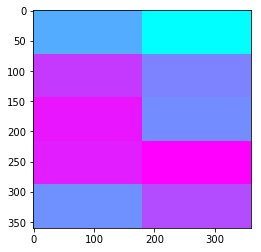

In [60]:
plt.imshow(cm, cmap = 'cool')

### All convolutional net heatmap

To create a higher resolution heatmap, we'll remove all the max pooling layers, and repear previous steps.

In [71]:
def get_lrg_layers():
    return [
        BatchNormalization(axis = 1, input_shape = conv_layers[-1].output_shape[1:]),
        Convolution2D(nf, (3,3), activation = 'relu', padding = 'same'),
        BatchNormalization(axis = 1),
        Convolution2D(nf, (3,3), activation = 'relu', padding = 'same'),
        BatchNormalization(axis = 1),
        Convolution2D(nf, (3,3), activation = 'relu', padding = 'same'),
        BatchNormalization(axis = 1),
        Convolution2D(8, (3,3), padding = 'same'),
        GlobalAveragePooling2D(),
        Activation('softmax')
    ]

In [75]:
lrg_model = Sequential(get_lrg_layers())

In [76]:
lrg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_17 (Batc (None, 512, 22, 22)       2048      
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 128, 22, 22)       589952    
_________________________________________________________________
batch_normalization_18 (Batc (None, 128, 22, 22)       512       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 128, 22, 22)       147584    
_________________________________________________________________
batch_normalization_19 (Batc (None, 128, 22, 22)       512       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 128, 22, 22)       147584    
_________________________________________________________________
batch_normalization_20 (Batc (None, 128, 22, 22)       512       
__________

In [77]:
lrg_model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [78]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size = batch_size, epochs = 2, validation_data = (conv_val_feat, val_labels))

Train on 499 samples, validate on 247 samples
Epoch 1/2
499/499 [==============================] - 140s - loss: 1.6992 - acc: 0.4369 - val_loss: 6.3039 - val_acc: 0.1984
Epoch 2/2
499/499 [==============================] - 135s - loss: 0.9115 - acc: 0.7415 - val_loss: 3.5375 - val_acc: 0.5425


In [79]:
lrg_model.optimizer.lr = 1e-5

In [81]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size = batch_size, epochs = 6, validation_data = (conv_val_feat, val_labels))

Train on 499 samples, validate on 247 samples
Epoch 1/6
499/499 [==============================] - 133s - loss: 0.5136 - acc: 0.8637 - val_loss: 6.6248 - val_acc: 0.2429
Epoch 2/6
499/499 [==============================] - 137s - loss: 0.2285 - acc: 0.9379 - val_loss: 2.9381 - val_acc: 0.5547
Epoch 3/6
499/499 [==============================] - 142s - loss: 0.1870 - acc: 0.9559 - val_loss: 5.4223 - val_acc: 0.2915
Epoch 4/6
499/499 [==============================] - 142s - loss: 0.0620 - acc: 0.9900 - val_loss: 3.0297 - val_acc: 0.5992
Epoch 5/6
499/499 [==============================] - 135s - loss: 0.0225 - acc: 1.0000 - val_loss: 2.9389 - val_acc: 0.5385
Epoch 6/6
499/499 [==============================] - 138s - loss: 0.0162 - acc: 1.0000 - val_loss: 1.8927 - val_acc: 0.6721


In [82]:
lrg_model.save_weights(path + '/models/lrg_0mp.h5')

In [83]:
lrg_model.load_weights(path + '/models/lrg_0mp.h5')

### Create heatmap

In [86]:
l = lrg_model.layers
conv_fn = K.function([l[0].input, K.learning_phase()], [l[-3].output])

In [91]:
def get_cm2(inp, label):
    conv = conv_fn([inp, 0])
    conv = conv[0][0][label]
    return scipy.misc.imresize(conv, (360, 360))

In [92]:
inp = np.expand_dims(conv_val_feat[0], 0)

In [ ]:
plt.imshow(to_plot(val[0]))

In [94]:
cm = get_cm2(inp, 0)

In [96]:
cm = get_cm2(inp, 4)

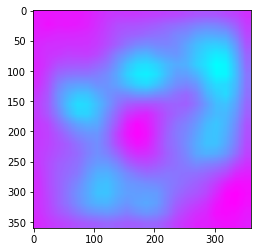

In [97]:
plt.imshow(cm, cmap = 'cool')

In [ ]:
plt.figure(figsize = (10, 10))
plot(val[0])
plt.imshow(cm, cmap = 'cool', alpha = 0.5)

### Inception mini-net

Here's an example of how to create and use 'inception blocks' - as you see, they use multiple different convolution filter sizes and concatenate the results together. We'll talk more about these next year.

In [108]:
def conv2d_bn(x, nb_filter, nb_row, nb_col, subsample = (1, 1)):
    x = Convolution2D(nb_filter, (nb_row, nb_col), subsample = subsample, activation = 'relu', padding = 'same')(x)
    return BatchNormalization(axis = 1)(x)

In [116]:
def incep_block(x):
    branch1x1 = conv2d_bn(x, 32, 1, 1, subsample = (2, 2))
    branch5x5 = conv2d_bn(x, 24, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 32, 5, 5, subsample = (2, 2))
    
    branch3x3dbl = conv2d_bn(x, 32, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 48, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 48, 3, 3, subsample = (2, 2))
    
    branch_pool = AveragePooling2D((3,3), strides = (2,2), border_mode = 'same')(x)
    branch_pool = conv2d_bn(branch_pool, 16, 1, 1)
    return merge([branch1x1, branch5x5, branch3x3dbl, branch_pool], mode = 'concat', concat_axis = 1)

In [118]:
inp = Input(vgg640.layers[-1].output_shape[1:])
x = BatchNormalization(axis = 1)(inp)
x = incep_block(x)
x = incep_block(x)
x = incep_block(x)
x = Dropout(0.75)(x)
x = Convolution2D(8, (3,3), border_mode = 'same')(x)
x = GlobalAveragePooling2D()(x)
outp = Activation('softmax')(x)

C:\Users\hjkim\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1), activation="relu", padding="same", strides=(2, 2))`
  
C:\Users\hjkim\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (1, 1), activation="relu", padding="same", strides=(1, 1))`
  
C:\Users\hjkim\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same", strides=(2, 2))`
  
C:\Users\hjkim\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1), activation="relu", padding="same", strides=(1, 1))`
  
C:\Users\hjkim\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), activation="relu", padding="same", strides=(1

In [120]:
lrg_model = Model([inp], outp)

In [121]:
lrg_model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [122]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size = batch_size, epochs = 2, validation_data = (conv_val_feat, val_labels))

Train on 499 samples, validate on 247 samples
Epoch 1/2
499/499 [==============================] - 108s - loss: 2.0838 - acc: 0.2365 - val_loss: 2.1202 - val_acc: 0.2065
Epoch 2/2
499/499 [==============================] - 71s - loss: 1.3180 - acc: 0.5792 - val_loss: 2.3708 - val_acc: 0.1943


In [123]:
lrg_model.optimizer.lr = 1e-5

In [124]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size = batch_size, epochs = 2, validation_data = (conv_val_feat, val_labels))

Train on 499 samples, validate on 247 samples
Epoch 1/2
499/499 [==============================] - 72s - loss: 0.8892 - acc: 0.7735 - val_loss: 2.0723 - val_acc: 0.1943
Epoch 2/2
499/499 [==============================] - 72s - loss: 0.6661 - acc: 0.8076 - val_loss: 1.8851 - val_acc: 0.2186


In [125]:
lrg_model.save_weights(path + '/models/lrg_nmp.h5')

In [126]:
lrg_model.load_weights(path + '/models/lrg_nmp.h5')

## Pseudo-labeling

In [129]:
preds = model.predict([conv_test_feats, test_sizes], batch_size = batch_size * 2)

NameError: name 'conv_test_feats' is not defined

In [ ]:
gen = image.ImageDataGenerator()

In [ ]:
test_batches = gen.flow(conv_test_feat, preds, batch_size = 16)

In [ ]:
val_batches = gen.flow(conv_val_fear, val_labels, batch_size = 4)

In [ ]:
batches = gen.flow(conv_feat, trn_labels, batch_size = 44)

In [ ]:
mi = MixIterator([batches, test_batches, val_batches])

In [ ]:
bn_model.fit_generator(mi, i.N, epochs = 8, validation_data = (conv_val_feat, val_labels))

## Submit

In [131]:
def do_clip(arr, mx): return np.clip(arr, (1-mx)/7, mx)

In [132]:
lrg_model.evaluate(conv_val_feat, val_labels, batch_size * 2)

247/247 [==============================] - 18s    


[1.8850863776226274, 0.21862348455649155]

In [133]:
preds = model.predict(conv_test_feat, batch_size = batch_size)

NameError: name 'model' is not defined

In [134]:
preds = preds[1]

NameError: name 'preds' is not defined

In [135]:
test = load_array(path + '/results/test_640.dat')

In [136]:
test = load_array(path + '/results/test.dat')

In [137]:
preds = conv_model.predict(test, batch_size = 32)

NameError: name 'conv_model' is not defined

In [138]:
subm = do_clip(preds, 0.82)

NameError: name 'preds' is not defined

In [139]:
subm_name = path + '/results/subm_bb.gz'

In [140]:
# classes = sorted(batches.class_indices, key = batches.class_indices.get)
classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

In [143]:
submission = pd.DataFrame(subm, column = classes)
submission.insert(0, 'image', raw_test_filenames)
submission.head()

NameError: name 'subm' is not defined

In [ ]:
submission.to_csv(subm_)